In [3]:
import useful as us
import skimage
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.linalg

In [2]:
data_dir = 'data_week1/'

In [14]:
def regularization_matrix(N, alpha, beta):
    """An NxN matrix for imposing elasticity and rigidity to snakes.
    Arguments: alpha is weigth for second derivative (elasticity),
    beta is weigth for (-)fourth derivative (rigidity)."""
    d = alpha*np.array([-2, 1, 0, 0]) + beta*np.array([-6, 4, -1, 0])
    D = np.fromfunction(lambda i,j: np.minimum((i-j)%N,(j-i)%N), (N,N), dtype=int)
    A = d[np.minimum(D,len(d)-1)]
    return(np.linalg.inv(np.eye(N)-A))

# taken from weekly solutions at gitlab
def curve_length(X):
    d = X - np.roll(X, shift=1, axis=0)
    d = (d**2).sum(axis=1)
    d = (np.sqrt(d)).sum()
    return(d)

(200, 2)


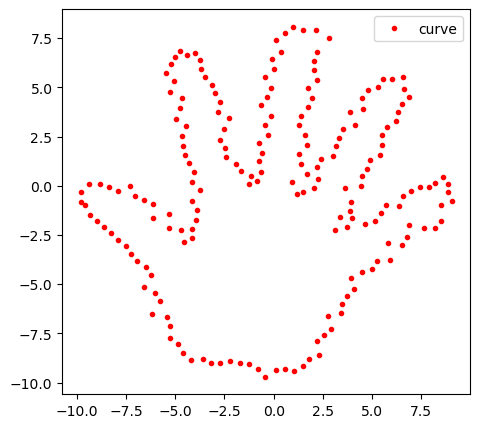

In [15]:
# Load the data
curve = np.loadtxt(data_dir + '/curves/hand_noisy.txt')
print(curve.shape)

# Plot the data
us.display_points([curve], ['r.'], ['curve'])

# Length of the curves

In [17]:
# First scenario
alpha = 100
beta = 0
X_alpha = regularization_matrix(curve.shape[0], alpha, beta) @ curve

# Second scenario
alpha = 0
beta = 100
X_beta = regularization_matrix(curve.shape[0], alpha, beta) @ curve

# Display the data
d = curve_length(X_alpha) - curve_length(X_beta)
print(f'Difference in length between the 2 curves: {d}')

Difference in length between the 2 curves: -38.44385657911269


# Mean curvature

In [18]:
# Mean curvature of the curve
b = 2 * curve - np.roll(curve, 1, axis=0) - np.roll(curve, -1, axis=0)
b = np.sqrt((b**2).sum(axis=1)).mean()

# Display the result
print(f'Mean curvature: {b:.2f}')

Mean curvature: 0.45


# Smoothing of a point

In [35]:
def smooth_curve(S, alpha, alpha_kernel, beta, beta_kernel):
    """
    Smooth the curve represented by points in S using the specified kernels and parameters.

    Parameters:
    S (ndarray): Array of shape (n, 2) representing n points in 2D space.
    alpha (float): Alpha parameter for the smoothing process.
    alpha_kernel (ndarray): Kernel for the alpha term.
    beta (float): Beta parameter for the smoothing process.
    beta_kernel (ndarray): Kernel for the beta term.

    Returns:
    ndarray: New position of the first point after one iteration of the smoothing process.
    """
    n = len(S)
    if n < len(alpha_kernel) or n < len(beta_kernel):
        raise ValueError("The number of points in S must be at least the length of the kernels.")
    
    # Calculate the alpha term
    alpha_term = sum(alpha_kernel[i] * S[(i - len(alpha_kernel) // 2) % n] for i in range(len(alpha_kernel)))
    
    # Calculate the beta term
    beta_term = sum(beta_kernel[i] * S[(i - len(beta_kernel) // 2) % n] for i in range(len(beta_kernel)))
    
    # Compute the new position of the first point
    new_position = S[0] + alpha * alpha_term + beta * beta_term
    
    return new_position

In [36]:
# The point and its neighbors
S = np.array([[0.1, 2.9], [1.2, 5.4], [3.3, 7.1], [3.5, 0.2], [1.4, 1.1]])

# Parameters
alpha = 0.05
alpha_kernel = np.array([0, 1, -2, 1, 0])
beta = 0.1
beta_kernel = np.array([-1, 4, -6, 4, -1])

# Position of the first point after one iteration of the smoothing process
new_position = smooth_curve(S, alpha, alpha_kernel, beta, beta_kernel)
print(f'Position of the first point after one iteration of the smoothing process: {new_position}')

Position of the first point after one iteration of the smoothing process: [0.52  3.065]


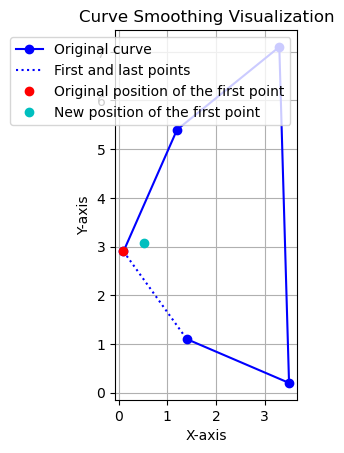

In [39]:
# Visualization
fig, ax = plt.subplots()
# Plot the original curve
ax.plot(S[:, 0], S[:, 1], 'b-o', label='Original curve')
# Plot the first and last points
ax.plot(S[[0, -1], 0], S[[0, -1], 1], 'b:', label='First and last points')
# Highlight the original position of the first point
ax.plot(S[0, 0], S[0, 1], 'ro', label='Original position of the first point')
# Highlight the new position of the first point
ax.plot(new_position[0], new_position[1], 'co', label='New position of the first point')

# Add a legend
ax.legend()
# Add titles and labels
ax.set_title('Curve Smoothing Visualization')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
# Add grid lines
ax.grid(True)
# Set equal aspect ratio
ax.set_aspect('equal')

plt.show()

# Alpha - beta smoothing

In [22]:
def smooth(data, alpha, beta):
    a = np.zeros(data.shape[0]) # Array for first order derivative
    a[[-1, 0, 1]] = [1, -2, 1]
    A = scipy.linalg.circulant(a) # Circulant matrix for first order derivative
    b = np.zeros(data.shape[0]) # Array for second order derivative
    b[[-2, -1, 0, 1, 2]] = [-1, 4, -6, 4, -1]
    B = scipy.linalg.circulant(b) # Circulant matrix for second order derivative
    return np.linalg.inv(np.eye(data.shape[0]) - alpha * A - beta * B) @ data

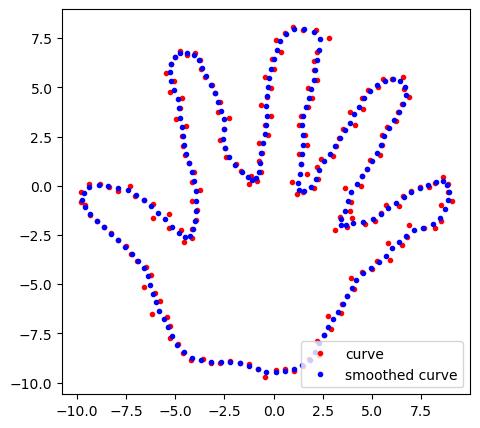

In [25]:
# Test the function
alpha = 0.1
beta = 1
smoothed_curve = smooth(curve, alpha, beta)

# Display the result
us.display_points([curve, smoothed_curve], ['r.', 'b.'], ['curve', 'smoothed curve'])

# Explicit smoothing

In [26]:
def explicit_smoothing(points, lambda_param, num_iterations):
    """
    Perform explicit smoothing on a set of points representing a curve.

    Parameters:
    points (numpy.ndarray): Array of shape (N, 2) representing the curve points.
    lambda_param (float): The smoothing parameter.
    num_iterations (int): The number of iterations for the smoothing process.

    Returns:
    numpy.ndarray: Smoothed points.
    """
    # Make the circulant smoothing matrix
    n_points = points.shape[0]
    l = np.zeros(n_points)
    l[[-1, 0, 1]] = [1, -2, 1]  # First column of the matrix
    L = scipy.linalg.circulant(l)

    # Initialize smoothed points
    smoothed_points = points.copy()

    # Apply the smoothing iteratively
    for _ in range(num_iterations):
        smoothed_points = (np.eye(n_points) + lambda_param * L) @ smoothed_points

    return smoothed_points

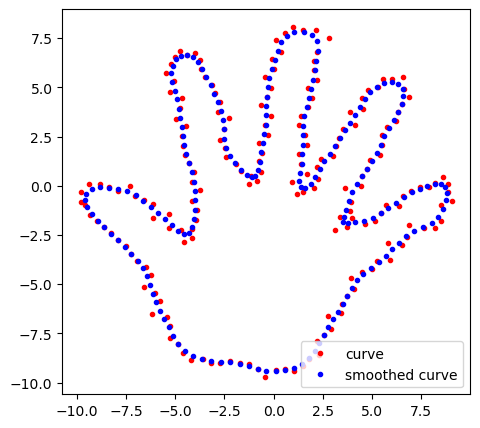

In [27]:
# Apply the explicit smoothing
lambda_param = 0.1
num_iterations = 10
smoothed_points = explicit_smoothing(curve, lambda_param, num_iterations)

# Display the result
us.display_points([curve, smoothed_points], ['r.', 'b.'], ['curve', 'smoothed curve'])

# Implicit smoothing

In [29]:
def implicit_smoothing(points, lambda_param):
    """
    Perform implicit smoothing on a set of points representing a curve.

    Parameters:
    points (numpy.ndarray): Array of shape (N, 2) representing the curve points.
    lambda_param (float): The smoothing parameter.

    Returns:
    numpy.ndarray: Smoothed points.
    """
    # Make the circulant smoothing matrix
    n_points = points.shape[0]
    l = np.zeros(n_points)
    l[[-1, 0, 1]] = [1, -2, 1]  # First column of the matrix
    L = scipy.linalg.circulant(l)

    # Apply the implicit smoothing
    smoothed_points = np.linalg.inv(np.eye(n_points) - lambda_param * L) @ points

    return smoothed_points

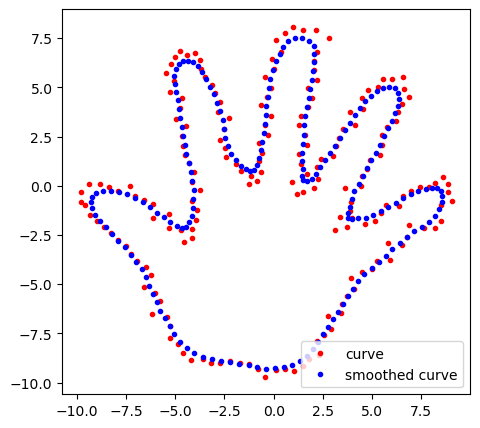

In [32]:
# Apply the implicit smoothing
lambda_param = 3.5
smoothed_points = implicit_smoothing(curve, lambda_param)

# Display the result
us.display_points([curve, smoothed_points], ['r.', 'b.'], ['curve', 'smoothed curve'])